## Exercícios

Neste exercício, você usará a classe `KMeans` que construímos para explorar um novo dataset e descobrir seus agrupamentos naturais.

O dataset escolhido é o **"Wine dataset"**, que contém a análise química de vinhos cultivados na mesma região da Itália, mas derivados de três cultivares (tipos de uva) diferentes. O objetivo é ver se o K-Means consegue agrupar os vinhos de acordo com seu cultivar, usando apenas as suas características químicas.

### Tarefa 1: Análise e Seleção de Features

Primeiro, carregue o dataset `wine` e use a função `seaborn.pairplot` para visualizar as relações entre as features. Analise o gráfico e escolha o par de features que você acredita que melhor separa os 3 grupos. Plote um gráfico de dispersão apenas com o par selecionado.

In [32]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_wine
from scipy.stats import mode

# Carregar o dataset wine
wine = load_wine()
X = wine.data
y_true = wine.target

# DataFrame para visualização
wine_df = pd.DataFrame(X, columns=wine.feature_names)
wine_df['class'] = pd.Series(y_true).map({0: 'Cultivar 0', 1: 'Cultivar 1', 2: 'Cultivar 2'})

# Gerar o pairplot
sns.pairplot(wine_df, hue='class', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot do Dataset Wine', y=1.02)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

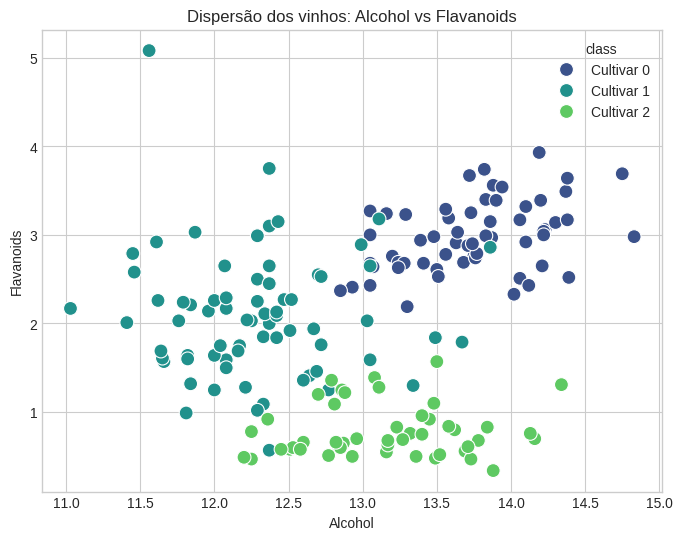

In [33]:
# Selecionar apenas duas features (Alcohol e Flavanoids)
X = X[:, [0, 5]]  # 0 = alcohol, 5 = flavanoids

# Exemplo de gráfico de dispersão com as features selecionadas
plt.figure(figsize=(8,6))
sns.scatterplot(data=wine_df, x='alcohol', y='flavanoids', hue='class', palette='viridis', s=100)
plt.title('Dispersão dos vinhos: Alcohol vs Flavanoids')
plt.xlabel('Alcohol')
plt.ylabel('Flavanoids')
plt.show()

### Tarefa 2: Encontrando o K Ótimo

Aplique o Método do Cotovelo nas duas features que você escolheu. Calcule e plote a inércia (WCSS) para K de 1 a 10. Com base no seu gráfico, qual parece ser o número ideal de clusters?

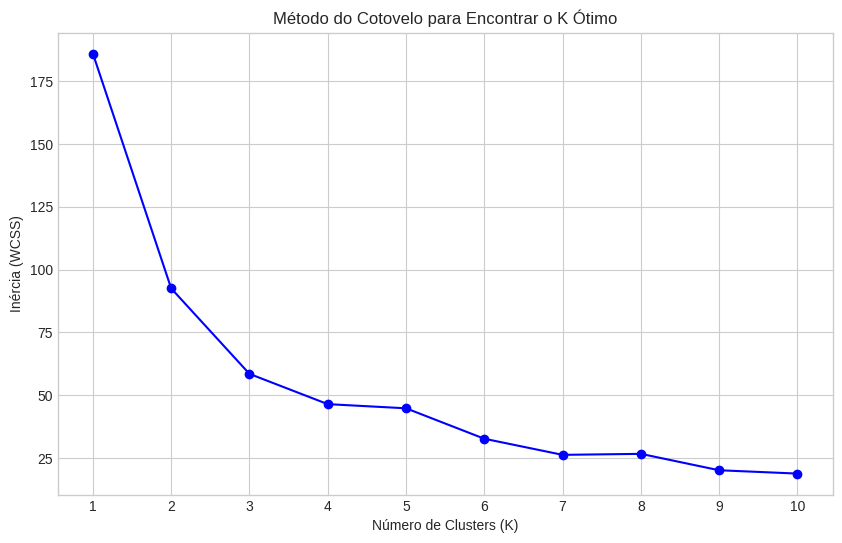

In [34]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """
        Inicializa os centróides selecionando K pontos aleatórios do dataset.
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

    def _assign_clusters(self, X):
        """
        Atribui cada ponto de dado ao centróide mais próximo.
        """
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, self.n_clusters))

        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)

        self.labels = np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        """
        Atualiza a posição de cada centróide com base na média dos pontos atribuídos a ele.
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))

        for i in range(self.n_clusters):
            cluster_points = X[self.labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[i] = self.centroids[i]

        self.centroids = new_centroids

    def fit(self, X):
        """
        Executa o algoritmo K-Means.
        """
        self._initialize_centroids(X)

        for _ in range(self.max_iter):
            old_centroids = self.centroids.copy()
            self._assign_clusters(X)
            self._update_centroids(X)
            if np.allclose(old_centroids, self.centroids):
                break

    def predict(self, X):
        """
        Atribui clusters para novos dados com base nos centróides aprendidos.
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)

        return np.argmin(distances, axis=1)

# Implementando o Método do Cotovelo com visualização iterativa
k_range = range(1, 11)
inertias = []
clustering_results = []

for k in k_range:
    model = KMeans(n_clusters=k, max_iter=150, random_state=42)
    model.fit(X)

    # Calcular a inércia (WCSS)
    current_inertia = 0
    for i in range(k):
        # Seleciona os pontos pertencentes ao cluster i
        cluster_points = X[model.labels == i]
        # Calcula a soma das distâncias quadradas ao centróide do cluster i
        current_inertia += np.sum((cluster_points - model.centroids[i])**2)

    inertias.append(current_inertia)
    clustering_results.append({'labels': model.labels, 'centroids': model.centroids})

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.title('Método do Cotovelo para Encontrar o K Ótimo')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Tarefa 3: Clusterização e Avaliação

Use o K encontrado na tarefa anterior para treinar seu modelo `KMeans`. Crie um gráfico com dois subplots: um mostrando os clusters encontrados pelo algoritmo e outro mostrando os dados com os rótulos reais para comparação. Por fim, calcule a taxa de acertos e comente o resultado.

In [35]:
# Instanciar e treinar o modelo K-Means
kmeans = KMeans(n_clusters=3, max_iter=150, random_state=42)
kmeans.fit(X)

In [36]:
# Obter os centróides finais e os rótulos dos clusters
final_centroids = kmeans.centroids
predicted_labels = kmeans.labels

print("Coordenadas dos Centróides Finais:")
print(final_centroids)

Coordenadas dos Centróides Finais:
[[13.17142857  1.64469388]
 [13.76730159  2.85174603]
 [12.1419697   2.24666667]]


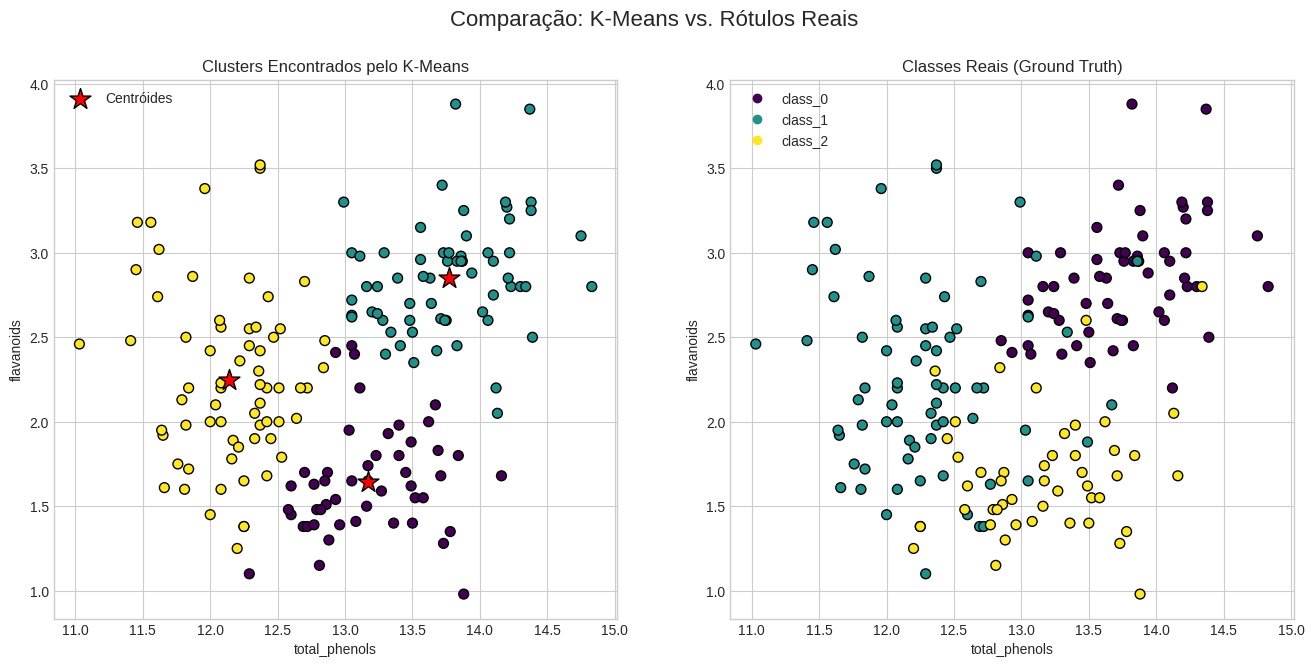

In [37]:
# Configurar a figura para plots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Clusters encontrados pelo K-Means
axes[0].scatter(X[:, 0], X[:, 1], c=predicted_labels, s=50, cmap='viridis', edgecolor='k')
axes[0].scatter(final_centroids[:, 0], final_centroids[:, 1], s=250, marker='*', c='red', edgecolor='black', label='Centróides')
axes[0].set_title('Clusters Encontrados pelo K-Means')
axes[0].set_xlabel(wine.feature_names[5])
axes[0].set_ylabel(wine.feature_names[6])
axes[0].legend()
axes[0].grid(True)

# Plot 2: Classes Reais do Dataset
scatter = axes[1].scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title('Classes Reais (Ground Truth)')
axes[1].set_xlabel(wine.feature_names[5])
axes[1].set_ylabel(wine.feature_names[6])
axes[1].legend(handles=scatter.legend_elements()[0], labels=wine.target_names.tolist())
axes[1].grid(True)

plt.suptitle('Comparação: K-Means vs. Rótulos Reais', fontsize=16)
plt.show()

In [38]:
from scipy.stats import mode
import numpy as np

correct_predictions = 0
n_samples = X.shape[0]

# Para cada label de cluster (0, 1, 2...)
for i in range(kmeans.n_clusters):
    # 1. Encontra todos os pontos de dados que foram atribuídos ao cluster 'i'
    mask = (predicted_labels == i)

    # 2. Dentre esses pontos, descobre qual é a classe real mais comum (a moda)
    # Se a maioria dos pontos no cluster 'i' for da classe real 2, assumimos que 'i' corresponde a 2
    dominant_label = mode(y_true[mask], keepdims=True)[0][0]

    # 3. Conta quantos pontos nesse cluster realmente pertencem a essa classe dominante
    hits = np.sum(y_true[mask] == dominant_label)

    # 4. Adiciona essa contagem ao total de acertos
    correct_predictions += hits

print(f"Número de acertos: {correct_predictions} de {n_samples} pontos.")
print(f"Taxa de acerto: {(correct_predictions / n_samples):.2%}")

Número de acertos: 149 de 178 pontos.
Taxa de acerto: 83.71%
